In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
import datetime as dt
from dateutil.relativedelta import *
from collections import Counter
from collections import defaultdict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from pandas_profiling import profile_report
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Funciones

In [2]:
def ks_test(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['target0']=data['target0'].astype('float64')
    try:
        data['bucket'] = pd.qcut(data[prob], 10)
    except:
        data.sort_values(by = prob, ascending = False, inplace = True)
        data.reset_index(inplace = True)
        array = np.array_split(data, 10)
        data_ = pd.DataFrame()
        for i in np.arange(0,10):
            array[i]['bucket'] = i+1
            data_ = data_.append(array[i])
            data_.reset_index(drop = True, inplace = True)
        data=data_.copy()
        del data_
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 6)
    print(kstable)
    
    #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

# 202210

## Evaluación modelo - full variables

In [2]:
df=pd.read_csv('../outputs/preds/pred_full_09-03-2023_23_36_20.csv',sep=';')
df.head()

,Unnamed: 0,pred,label,Edad,Ingresos,Número de hijos,Puntuación de crédito,Monto del seguro,start_date_day,start_date_month,start_date_weekday,Sexo_Masculino,Tipo de hogar_Departamento,Estado civil_Divorciado,Estado civil_Soltero,Estado civil_Viudo,Tipo de trabajo_Empresario,Tipo de trabajo_Independiente,Educación_Preparatoria,Educación_Universidad,Tipo de seguro_Hogar,Tipo de seguro_Salud,Tipo de seguro_Vida
0,0,0.148826,0,40,843237,1,791,7339,30,8,1,0,1,1,0,0,0,0,0,1,0,1,0
1,1,0.148826,0,44,796026,3,684,3898,28,11,0,0,0,0,0,0,1,0,0,0,0,0,1
2,2,0.148826,0,70,859665,4,436,1203,11,11,4,1,1,0,0,1,1,0,1,0,1,0,0
3,3,0.148826,0,76,215614,3,807,1156,29,3,1,0,0,1,0,0,1,0,0,1,0,1,0
4,4,0.140189,0,26,923520,0,584,6104,19,1,3,1,0,0,0,1,0,0,0,1,0,0,1


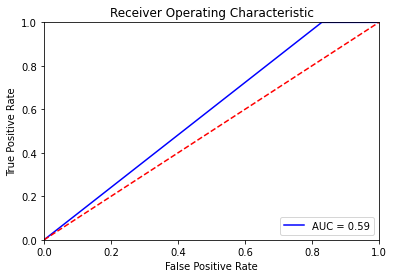

In [5]:
fpr, tpr, threshold = roc_curve(df['label'],df['pred'])
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [6]:
roc_auc_score(df['label'],df['pred'])

0.5852864583333333

In [7]:
ks=ks_test(data=df,target='label', prob='pred')
ks.to_csv('outputs/ks/ks_test_full.csv')
ks

        min_prob  max_prob  events  ...  cum_eventrate cum_noneventrate    KS
Decile                              ...                                      
1       0.148826  0.148826      10  ...          7.58%           10.42%  -2.8
2       0.148826  0.148826      16  ...         19.70%           20.05%  -0.4
3       0.148826  0.148826      14  ...         30.30%           29.95%   0.4
4       0.148826  0.148826      15  ...         41.67%           39.71%   2.0
5       0.148826  0.148826      17  ...         54.55%           49.22%   5.3
6       0.148826  0.148826      16  ...         66.67%           58.85%   7.8
7       0.148826  0.148826      16  ...         78.79%           68.49%  10.3
8       0.148826  0.148826      17  ...         91.67%           77.99%  13.7
9       0.140189  0.148826      11  ...        100.00%           88.28%  11.7
10      0.140189  0.140189       0  ...        100.00%          100.00%   0.0

[10 rows x 9 columns]
KS is 13.700000000000001% at decile 8


,min_prob,max_prob,events,...,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,
1,0.148826,0.148826,10,...,7.58%,10.42%,-2.8
2,0.148826,0.148826,16,...,19.70%,20.05%,-0.4
3,0.148826,0.148826,14,...,30.30%,29.95%,0.4
4,0.148826,0.148826,15,...,41.67%,39.71%,2.0
5,0.148826,0.148826,17,...,54.55%,49.22%,5.3
6,0.148826,0.148826,16,...,66.67%,58.85%,7.8
7,0.148826,0.148826,16,...,78.79%,68.49%,10.3
8,0.148826,0.148826,17,...,91.67%,77.99%,13.7
9,0.140189,0.148826,11,...,100.00%,88.28%,11.7
